### The central visible galaxies change the velocities of the surrounding invisible matter in dark matter halos even far from center.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys, json, os
sys.path.append('..')
from project.constants import Constants as pc
from project.recoil import Nuclear as Nr
from project.recoil import get_vdf_ert, norm , p50
import pickle

import warnings
warnings.filterwarnings("ignore", message="Attempt to set non-positive ylim on a log-scaled axis will be ignored.")

In [2]:
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))
mwd = MW_dict['vdf_RCfit']

# 1. Find the Benchmark scenario ($m,\, \sigma_p,\, E_\mathrm{thr},\, \omega)$

In [3]:
ng = 100
Mdm = np.logspace(0, 1, ng)
Sdm = np.logspace(-48, -44, ng)
Mgrid, Sgrid = np.meshgrid(Mdm, Sdm)
blgrid = np.ones(Mgrid.shape)*0

nr1 = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']), 
         vcirc=p50(mwd['vcircs']), Eroi=5.0, Ethr=1.0, ω=1.0, 
         rhosun=p50(mwd['rhosuns']))

nr10 = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']), 
         vcirc=p50(mwd['vcircs']), Eroi=5.0, Ethr=0.1, ω=10.0, 
         rhosun=p50(mwd['rhosuns']))

N1 = nr1.totNgrid(Mgrid, Sgrid, blgrid)
N10 = nr10.totNgrid(Mgrid, Sgrid, blgrid)

S1, S10 = nr1.σpMdmNsg(Mdm), nr10.σpMdmNsg(Mdm)

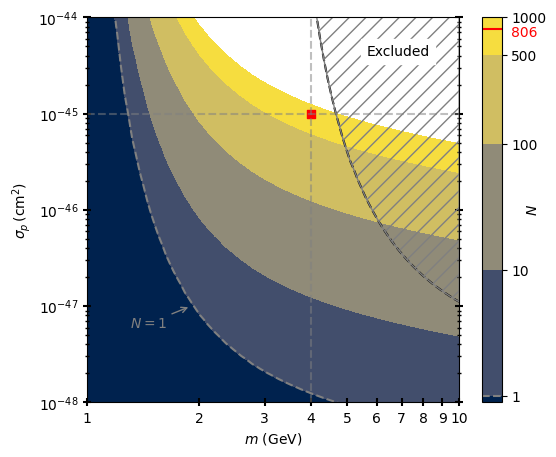

In [4]:
fig, ax = plt.subplots(figsize = (6,5))

ax.plot(Mdm, S1, c = 'k', ls = '--')
ax.fill_between(Mdm, S1, np.ones(Mdm.shape)*1e-40, color = 'grey', hatch = '//', facecolor = 'None',zorder = 2)
ax.text(0.75, 0.9, 'Excluded', backgroundcolor = 'white', transform = ax.transAxes)

cn = ax.contourf(Mgrid, Sgrid, N10, levels = [0, 1, 10, 100, 500, 1000], norm = "log", cmap = 'cividis')
cbar = fig.colorbar(cn, format = '%i')
ax.plot(Mdm, S10, c = 'grey', ls = '--')

ax.set_xlabel('$m$ (GeV)')
ax.set_ylabel('$\sigma_p \, (\mathrm{cm}^2)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-48, 1e-44)

ax.set_xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]);
ax.tick_params(axis = 'both', which = 'both', right = True, left = True, direction = 'inout')
ax.tick_params(which = 'major', width = 1.5, length = 6)
ax.tick_params(which = 'minor', width = 1, length = 3)

m,sp = 4, 1e-45

ax.scatter(m, sp, c = 'r', marker = 's', s = 30)
ax.plot([m,m],[1e-48,1e-44], c = 'grey', ls = '--', alpha = 0.5)
ax.plot([1,10], [sp,sp], c = 'grey', ls = '--', alpha = 0.5);

Ntot = nr10.totNtot(m, sp)

cbar.ax.plot([0, 1], [Ntot, Ntot], color='red', linewidth=1.5)
cbar.ax.plot([0, 1], [1, 1], color='grey', linewidth=1.5, ls = '--')
cbar.ax.text(1.5, Ntot-100, '%i'%Ntot, color = 'r')
cbar.set_label('$N$', labelpad = -15)

ax.annotate('$N = 1$', xy=(1.9, 1e-47), xytext=(1.3, 6e-48), color = 'grey',
            arrowprops=dict(arrowstyle='->',color = 'grey'));

# plt.savefig('../Output/figures/nuclear/Exclusion_limit.png', bbox_inches = 'tight', dpi = 300)

# 2. Create mock data

## (i) Without background

In [5]:
#differntial recoil plot
nr = Nr('Xe',vE= mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']),
        vcirc=p50(mwd['vcircs']), rhosun=p50(mwd['rhosuns']), Ethr=0.1,
        Eroi=5.0, ω=10.0)
m, sp = 4.0, 1e-45
bins = np.linspace(0.1, 5, 50)

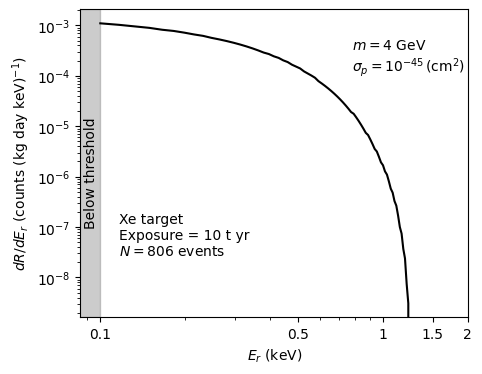

In [6]:
fig, ax = plt.subplots(figsize = (5,4))

ax.plot(nr.E, nr.diffSg(m, sp), c = 'k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.085,2)
ylim = ax.get_ylim()

ax.fill_betweenx(ylim, 0.1, 0, color = 'grey', alpha = 0.4)
ax.text(0.01, 0.3, 'Below threshold', size = 10, rotation = 90, transform = ax.transAxes)
ax.set_ylim(ylim)

ax.set_xlabel('$E_r$ (keV)')
ax.set_ylabel('$dR/dE_r$ (counts (kg day keV)$^{-1}$)')
ax.set_xticks([0.1, 0.5, 1, 1.5, 2], [0.1, 0.5, 1, 1.5, 2])

ax.text(0.7, 0.8, '$m = 4$ GeV \n$\sigma_p = 10^{-45} \, (\mathrm{cm}^2)$', transform = ax.transAxes)
ax.text(0.1, 0.2, f'Xe target \nExposure = 10 t yr \n$N = {int(nr.totNtot(m, sp))}$ events', transform = ax.transAxes);

# plt.savefig('../Output/figures/nuclear/Differential_recoil_sg.png',bbox_inches = 'tight', dpi = 300)

Text(0, 0.5, '# events')

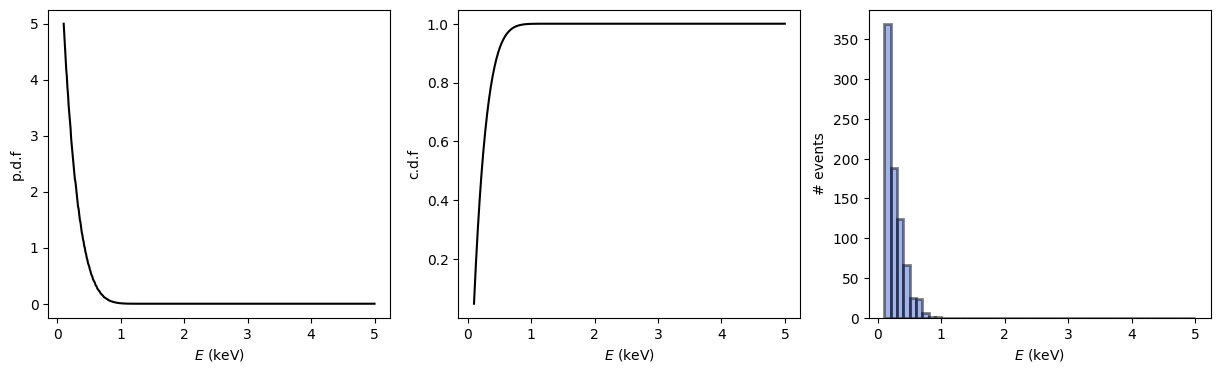

In [7]:
sampd = nr.mocksample(m, sp)

fig, axs = plt.subplots(1,3, figsize = (15,4))
ax1, ax2, ax3 = axs

ax1.plot(sampd['E_array'], sampd['pdf'], c = 'k')
ax2.plot(sampd['E_array'], sampd['cdf'], c = 'k')
ax3.hist(sampd['Esample'], bins = bins, color = 'royalblue', histtype = 'bar', lw = 2, alpha = 0.5, edgecolor = 'k');

for ax in axs:
    ax.set_xlabel('$E$ (keV)')
    # ax.set_xlim(0, 2)
ax1.set_ylabel('p.d.f')
ax2.set_ylabel('c.d.f')
ax3.set_ylabel('# events')

# plt.savefig('../Output/figures/nuclear/mock_samples.png', bbox_inches = 'tight', dpi = 300)

## (ii) With constant (in E) background

In [8]:
nrb = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], vesc=p50(mwd['vescs']),
         vcirc=p50(mwd['vcircs']), rhosun=p50(mwd['rhosuns']), Ethr=0.1,
         Eroi=5.0, ω=10.0)
bins = np.linspace(0.1, 5, 50)

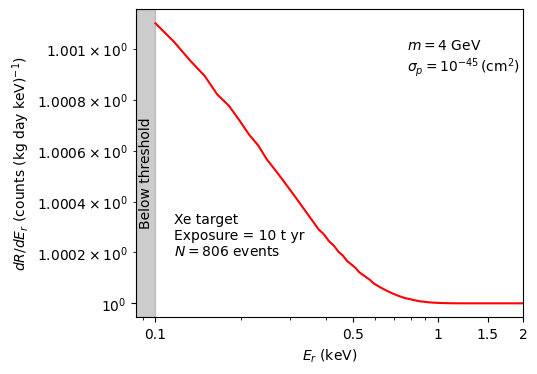

In [49]:
fig, ax = plt.subplots(figsize = (5,4))

ax.plot(nr.E, nr.diffTot(m, sp, bl = 1), c = 'r')
# ax.plot(nr.E, nr.diffTot(m, sp, bl = 0), c = 'k', ls = '--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.085,2)

ylim = ax.get_ylim()
ax.fill_betweenx(ylim, 0.1, 0, color = 'grey', alpha = 0.4)
ax.set_ylim(ylim)
ax.text(0.01, 0.3, 'Below threshold', size = 10, rotation = 90, transform = ax.transAxes)

ax.set_xlabel('$E_r$ (keV)')
ax.set_ylabel('$dR/dE_r$ (counts (kg day keV)$^{-1}$)')
ax.text(0.7, 0.8, '$m = 4$ GeV \n$\sigma_p = 10^{-45} \, (\mathrm{cm}^2)$', transform = ax.transAxes)
ax.text(0.1, 0.2, f'Xe target \nExposure = 10 t yr \n$N = {int(nrb.totNsg(m, sp))}$ events', transform = ax.transAxes)

ax.set_xticks([0.1, 0.5, 1, 1.5, 2], [0.1, 0.5, 1, 1.5, 2]);

plt.savefig('../Output/figures/nuclear/Differential_recoil_bg.png',bbox_inches = 'tight', dpi = 300)

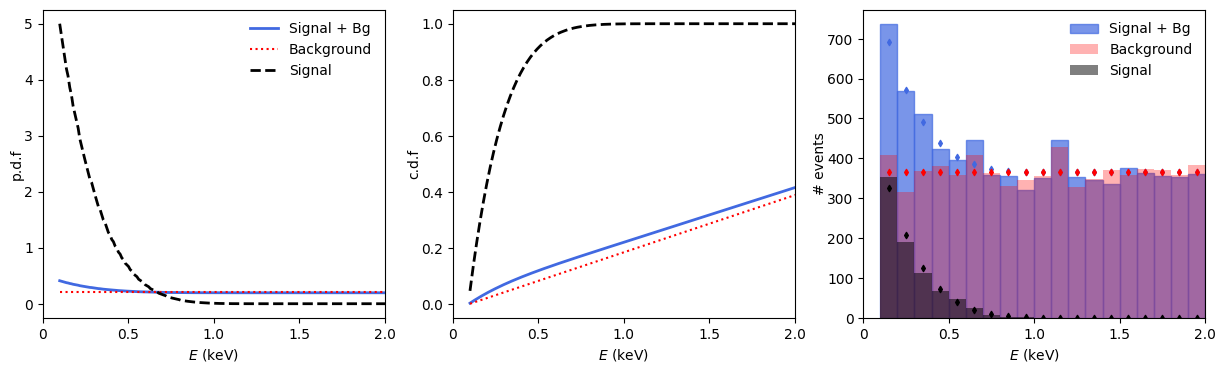

In [10]:
sp = 1e-45
bins = np.linspace(0.1, 5.0, 50)
sampd = nrb.mocksample(m, sp, Ntot = 'mean', bl = 0.001)
samp = sampd['Esample']
E = sampd['E_array']

fig, axs = plt.subplots(1,3, figsize = (15,4))
ax1, ax2, ax3 = axs

ax1.plot(E, norm(sampd['pdf'], E), c = 'royalblue', lw = 2, label='Signal + Bg')
ax2.plot(E, sampd['cdf'], c = 'royalblue', lw = 2)
ax3.hist(samp, bins = bins, color = 'royalblue', histtype = 'bar', lw = 1, alpha = 0.7,  edgecolor = 'royalblue', label = 'Signal + Bg');

bd = nrb.mocksample(0, sp, bl = 0.001)
ax1.plot(bd['E_array'], norm(bd['pdf'], E), c = 'r', ls = ':', label = 'Background')
ax2.plot(bd['E_array'], bd['cdf'], c = 'r', ls = ':')
ax3.hist(bd['Esample'], bins = bins, color = 'r', histtype = 'bar', lw = 2, alpha = 0.3, label = 'Background');

sd = nrb.mocksample(m, sp, bl = 0.)
ax1.plot(sd['E_array'], norm(sd['pdf'], E), c = 'k', ls = '--', lw = 2, label='Signal')
ax2.plot(sd['E_array'], sd['cdf'], c = 'k', ls = '--', lw = 2)
ax3.hist(sd['Esample'], bins = bins, color = 'k', histtype = 'bar', alpha = 0.5, label = 'Signal')

ax1.legend(framealpha = 0)
ax3.legend(framealpha = 0)


for ax in axs:
    ax.set_xlabel('$E$ (keV)')
    ax.set_xlim(0, 2)
    ax.set_xticks([0,0.5,1.0,1.5,2.0], [0,0.5,1.0,1.5,2.0])
    
ax1.set_ylabel('p.d.f', labelpad = 0)
ax2.set_ylabel('c.d.f', labelpad = 0)
ax3.set_ylabel('# events', labelpad = 0)

bint = nrb.binTot(m, sp, 0.001, bin_edges = bins)
ax3.scatter(bint['E_center'], bint['Neachbin'], c= 'royalblue', marker = 'd', s = 10)
bint = nrb.binTot(0, sp, 0.001, bin_edges = bins)
ax3.scatter(bint['E_center'], bint['Neachbin'], c= 'r', marker = 'd', s = 10)
bint = nrb.binTot(m, sp, 0, bin_edges = bins)
ax3.scatter(bint['E_center'], bint['Neachbin'], c= 'k', marker = 'd', s = 10)

# plt.savefig('../Output/figures/nuclear/mock_samples_bg.png', bbox_inches = 'tight', dpi = 300)

## (iii) A potential problem?

In [11]:
from tqdm.notebook import tqdm
size = 1000

E0bin = np.linspace(0.1, 0.2, 10)
λ0_poiss = np.random.poisson(nrb.totNtot(m, sp, 0.001, E=E0bin), size=size)
λ0_fmock = []
for i in tqdm(range(size)):
    sd = nrb.mocksample(m, sp, 0.001, Ntot = 'mean')
    hist = np.histogram(sd['Esample'], bins = np.linspace(0.1, 5.0, 50))
    λ0_fmock.append(hist[0][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

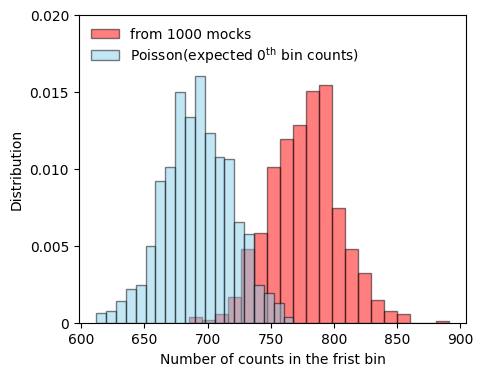

In [48]:
fig,ax = plt.subplots(figsize=(5,4))

ax.hist(λ0_fmock, bins = 20, color = 'red', density = True, alpha = 0.5, edgecolor = 'k', label = 'from 1000 mocks')
ax.hist(λ0_poiss, bins = 20, color = 'skyblue', density = True, alpha = 0.5, edgecolor = 'k', label = 'Poisson(expected $0^\mathrm{th}$ bin counts) ')

ax.legend(framealpha = 0, loc = 'upper left', labelspacing = 0.2)
ax.set_ylim(0,0.02)
ax.set_yticks([0,0.005, 0.010, 0.015, 0.02], [0,0.005,'0.010',0.015,"0.020"])

ax.set_xlabel('Number of counts in the frist bin')
ax.set_ylabel('Distribution')

# plt.savefig('../Output/figures/nuclear/First_bin_count_prob.png', bbox_inches = 'tight', dpi = 300)

# 3. Profile likelihood with background level ($b_l$) as nuicance parameter ($\nu$)

In [ ]:

from project.recoil import binSamp

bind = binSamp(sample = sampd['sample'], bin_edges = bins, accuracy = 5)
bint = nrb.binTot(m, sp, bl = 0.001, bin_edges = bins, accuracy = 5)

fig, ax = plt.subplots(figsize = (6,4))
ax.hist(sampd['sample'], bins = bins, color = 'royalblue', alpha = 0.4, histtype = 'bar', edgecolor = 'k', label = 'Mock observation')
ax.scatter(bint['E_center'], bint['Neachbin'], c = 'r', s = 5, label = 'Predicted (m = 4GeV, $\sigma_p = 10^{-45} \, \mathrm{cm}^2$) ')
ax.legend()

ax.set_xlabel('E (keV)')
ax.set_ylabel('# events')
print ()
# plt.savefig('../Output/figures/nuclear/mock_vs_pred.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
from project.recoil import Loglike as Ll
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore", 'RuntimeWarning')

Ngrid = 10
Mdm = np.logspace(0, 1, Ngrid)
Sdm = np.logspace(-46, -44, Ngrid)
Ldm = np.zeros([Ngrid,Ngrid])
Bdm = np.zeros([Ngrid,Ngrid])

ll = Ll(nrb, bsamp)

Mdm_grid, Sdm_grid = np.zeros([Ngrid,Ngrid]), np.zeros([Ngrid,Ngrid])
for i,mdm in tqdm(enumerate(Mdm)):
    for j, sdm in enumerate(Sdm):
        ll.mdm_sdm(mdm, sdm)
        func = lambda bl: np.log10(np.abs(ll.nllike(bl)))
        res = minimize(func, x0 = 0.001).x[0]
        Ldm[i,j] = func(res)
        Bdm[i,j] = res
        Mdm_grid[i,j] = mdm
        Sdm_grid[i,j] = sdm

In [ ]:
sp = 1e-45
fig, ax = plt.subplots(figsize = (5,4))
# cn = ax.scatter(Mdm_grid, Sdm_grid, c = Ldm, cmap = 'viridis')
NL = -10**Ldm
ts = 2 * (NL - np.min(NL))
cn = ax.contourf(Mdm_grid, Sdm_grid, ts, levels = [0, 5.99, 9.21])
indx = np.where(Ldm == np.min(Ldm))
ax.scatter(Mdm_grid[indx], Sdm_grid[indx], c = 'k',zorder = 2, s = 10)
ax.scatter(m, sp, c = 'r', marker = 's')
# ax.set_xscale('log')
ax.set_yscale('log')
cbar = fig.colorbar(cn)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]);

In [ ]:
from iminuit import Minuit

In [ ]:
from tqdm.notebook import tqdm

# nr = Nr('Xe', mwd['vE'], mwd['vdfE_50'], 544., 220., 0.4)

Mdm = np.logspace(0,1,100)
Sdm = np.zeros(Mdm.shape)
for i, mdm in tqdm(enumerate(Mdm)):
    Ntot_0 = nr.totN(mdm, 1e-46, nr.E, Emin = 0.1)
    if Ntot_0 == 0:
        Ntot_0 = 1e-10
    Sdm[i] = 1e-46/Ntot_0

In [ ]:
fig, ax = plt.subplots(figsize = (5,4))

ax.plot(Mdm, Sdm*3, color = 'k', lw = 1, ls = '--', label = '$N(m, \sigma_p) = 3$')
ax.fill_between(Mdm, Sdm*5, Sdm*1, color = 'k', alpha = 0.3, lw = 0, label = '$1 < N < 5$')
ax.legend(framealpha = 0)

ax.set_yscale('log')
ax.set_xlim(0,10)
ax.set_ylim(1e-48,1e-44)

ax.set_xlabel('$m$ (GeV)')
ax.set_ylabel('$\sigma_p \, (\mathrm{cm}^2$)')

ax.text(0.7, 0.5, 'Xe Targer \n$\omega$ = 1 $\mathrm{t\,\,yr}$ \n$E_\mathrm{thr}$ = 0.1 keV', transform = ax.transAxes)

ax.set_title('$\Delta m_\mathrm{stat}$')

# $\Delta m_\mathrm{MW}$

In [ ]:
mwd.keys()

In [ ]:
mwd['vdfEs'].shape

In [ ]:
for i, mdm in tqdm(enumerate(Mdm)):
    Ntot_0 = nr.totN(mdm, 1e-46, nr.E, Emin = 0.1)
    if Ntot_0 == 0:
        Ntot_0 = 1e-10
    Sdm[i] = 1e-46/Ntot_0

In [ ]:
chain_len = mwd['vdfEs'].shape[0]
Mdm = np.logspace(0,1,50)

Dm_MW = {}
for i in tqdm(range(0, chain_len, 5)):
    
    # nr = Nr('Xe', mwd['vE'], mwd['vdfEs'][i], mwd['vescs'][i],
    #         mwd['vcircs'][i], rhosun = mwd['rhosuns'][i])
    Sdm = np.zeros(Mdm.shape)
    
    for j, mdm in enumerate(Mdm):
        Ntot_0 = nr.totN(mdm, 1e-46, nr.E, Emin = 0.1)
        Ntot_0 = 1e-10 if Ntot_0 == 0 else Ntot_0
        Sdm[j] = 1e-46/Ntot_0
        
    Dm_MW[f'{i}'] = Sdm

In [ ]:
fig, ax = plt.subplots(figsize = (5,4))

for i in range(0, chain_len, 5):
    Sdm = Dm_MW[f'{i}']
    ax.plot(Mdm, Sdm, c = 'r', alpha = 0.2, lw = 0.5)

ax.set_yscale('log')
ax.set_ylim(1e-48,1e-44)